In [58]:
import jax
import jax.numpy as jnp
import numpy as np
import optax
import equinox as eqx
from jax import random
from jax.random import PRNGKey, split
from jax import jit, grad
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.style as mplstyle

import seaborn as sns

from mnist1d.data import make_dataset, get_dataset_args, get_templates


In [59]:
plt.style.use('default')
sns.set_theme(context='paper', style='white', palette='icefire', font='serif',
            font_scale=1, color_codes=True, rc={'text.usetex' : True})
mplstyle.use('fast')

In [60]:
def plot_1dmnist(xs, t, labels=None, ratio=2.6, dark_mode=False, zoom=1):
    rows, cols = 1, 10
    fig = plt.figure(figsize=[cols*1.5,rows*1.5*ratio], dpi=60)
    for r in range(rows):
        for c in range(cols):
            ix = r*cols + c
            x, t = xs[ix], t
            ax = plt.subplot(rows,cols,ix+1)

            if dark_mode:
                plt.plot(x, t, 'wo', linewidth=6)
                ax.set_facecolor('k')
            else:
                plt.plot(x, t, 'k-', linewidth=2)
            if labels is not None:
                plt.title("label=" + str(labels[ix]), fontsize=22)

            plt.xlim(-zoom,zoom) ; plt.ylim(-zoom,zoom)
            plt.gca().invert_yaxis() ; plt.xticks([], []), plt.yticks([], [])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout() ; plt.show()
    return fig

In [61]:
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')

In [62]:
class Model(eqx.Module):
    layers: list

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))
        return self.layers[-1](x)

In [63]:
def MLP(layer_sizes, key):
    keys = split(key, len(layer_sizes) - 1)
    layers = [
        eqx.nn.Linear(in_size, out_size, key=k)
        for in_size, out_size, k in zip(layer_sizes[:-1], layer_sizes[1:], keys)
    ]
    return Model(layers)

In [64]:
@eqx.filter_jit()
def cross_entropy(y, pred_y):
    # y are the true targets, and should be integers 0-9.
    # pred_y are the log-softmax'd predictions.
    pred_y = jnp.take_along_axis(pred_y, jnp.expand_dims(y, 1), axis=1)
    return -jnp.mean(pred_y)

In [65]:
@eqx.filter_value_and_grad()
def compute_loss(params, x, y):
    pred_y = jax.nn.log_softmax(jax.vmap(params)(x))
    loss = cross_entropy(y, pred_y)
    return loss

In [66]:
@eqx.filter_jit()
def accuracy(mlp, x, y):
    logits = jax.vmap(mlp)(x)
    return jnp.mean(jnp.argmax(logits, axis=-1) == y)

In [67]:
@eqx.filter_jit()
def train_step(params, x, y, opt_state, opt_update):
    loss, grads = compute_loss(params, x, y)
    updates, opt_state = opt_update(grads, opt_state)
    params = eqx.apply_updates(params, updates)
    return loss, params, opt_state

In [68]:
# Compute the gradient norm
@eqx.filter_jit()
def grad_norm(grads):
    return jnp.sqrt(sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(grads)))


In [69]:
input_size = 40
hidden_sizes = [128, 128] 
output_size = 1
num_epochs = 25000
seed = 0
threshold = 1e-4
grad_norm_threshold = 1e-3
n_samples = 20000
test_size = 0.2
learning_rate = 3e-4

In [70]:
data_config = get_dataset_args()
data_config.num_samples = n_samples
data_config.shuffle_seq = True

In [71]:
data = make_dataset(data_config)
x_train, y_train = data["x"], data["y"]
x_test, y_test = data["x_test"], data["y_test"]
template = data["t"]

In [72]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, template.shape

((16000, 40), (16000,), (4000, 40), (4000,), (40,))

(array([1613., 1598., 1597., 1614., 1571., 1589., 1597., 1602., 1600.,
        1619.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

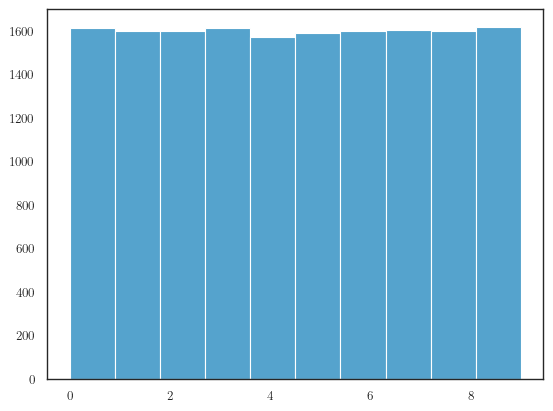

In [73]:
plt.hist(y_train, bins=10)

Templates for the MNIST-1D dataset:


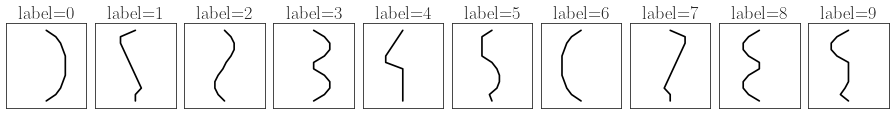

In [74]:
templates = get_templates()
print("Templates for the MNIST-1D dataset:")
x = templates['x']
t = templates['t']
y = templates['y']
fig = plot_1dmnist(x, t, labels=y, ratio=1.33, dark_mode=False)

In [75]:
# Main training function
def train_mlp(num_epochs=1000, learning_rate=3e-4):
    key = random.PRNGKey(0)
    layer_sizes = [40, 128, 128, 10]  # Input layer, two hidden layers, and output layer
    model = MLP(layer_sizes, key)
    opt = optax.adam(learning_rate)
    opt_state = opt.init(model)
    train_loss_history = []
    test_loss_history = []

    # Training loop
    for epoch in range(num_epochs):
        loss, model, opt_state = train_step(model, x_train, y_train, opt_state, opt.update)
        _, grads  = compute_loss(model, x_train, y_train)
        grad_norm_val = grad_norm(grads)
        train_loss_history.append(loss)
        if (epoch + 1) % 100 == 0:
            test_loss, _ = compute_loss(model, x_test, y_test)
            test_loss_history.append(test_loss)
            print(f'Epoch {epoch + 1}, Train Loss: {loss}, Test loss: {test_loss}, Grad norm: {grad_norm_val}')

    return model, train_loss_history, test_loss_history


In [76]:
model, train_loss_history, test_loss_history = train_mlp(num_epochs=25000)
n_nodes = model.layers[0].in_features + sum([layer.out_features for layer in model.layers]) 
node_history = [n_nodes] * len(train_loss_history)

Epoch 100, Train Loss: 1.733960509300232, Test loss: 1.7504169940948486, Grad norm: 0.13787351548671722
Epoch 200, Train Loss: 1.5976922512054443, Test loss: 1.6180731058120728, Grad norm: 0.08531560003757477
Epoch 300, Train Loss: 1.457998514175415, Test loss: 1.4851343631744385, Grad norm: 0.10774200409650803
Epoch 400, Train Loss: 1.2901606559753418, Test loss: 1.332070231437683, Grad norm: 0.09482383728027344
Epoch 500, Train Loss: 1.138108730316162, Test loss: 1.1937354803085327, Grad norm: 0.0873638167977333
Epoch 600, Train Loss: 0.9708073139190674, Test loss: 1.043796181678772, Grad norm: 0.08542805165052414
Epoch 700, Train Loss: 0.8063138723373413, Test loss: 0.9021036624908447, Grad norm: 0.07540040463209152
Epoch 800, Train Loss: 0.6756919622421265, Test loss: 0.7988535761833191, Grad norm: 0.06355087459087372
Epoch 900, Train Loss: 0.5746826529502869, Test loss: 0.7271316647529602, Grad norm: 0.05437204986810684
Epoch 1000, Train Loss: 0.494672566652298, Test loss: 0.67874

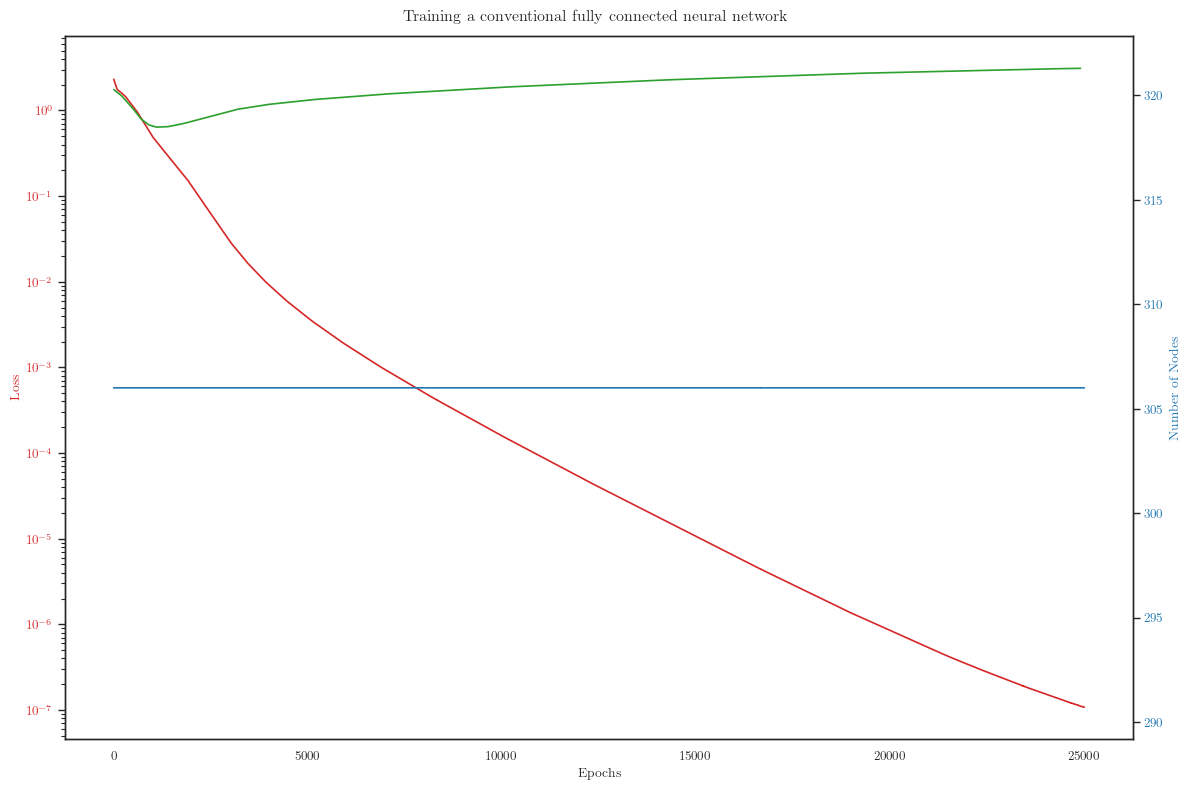

In [77]:
fig, ax1 = plt.subplots(figsize=(12, 8))
num_epochs = len(train_loss_history)
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(0,num_epochs), train_loss_history, color=color)
ax1.plot(np.arange(0,num_epochs,100), test_loss_history, color='tab:green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Number of Nodes', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0,num_epochs), node_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.suptitle("Training a conventional fully connected neural network")
fig.tight_layout()

In [78]:
logits = jax.vmap(model)(x_test)
acc = jnp.mean(jnp.argmax(logits, axis=-1) == y_test)

In [79]:
acc

Array(0.75900006, dtype=float32)